Time Step Comparison of Var Value for different Methods

In [27]:
# Compare Variational Objectives Across Methods
# Computes and visualizes the variational objective for trajectories from different optimization methods

import Pkg; Pkg.activate(@__DIR__)
Pkg.instantiate();
using PiccoloQuantumObjects
using NamedTrajectories
using QuantumCollocation
using LinearAlgebra
using Statistics
using CairoMakie
using JLD2
using Printf
using Glob
using Dates

  Activating project at `~/Documents/research/pulses/project/notebooks/src`
┌ Warning: Circular dependency detected.
│ Precompilation will be skipped for dependencies in this cycle:
│  ┌ Piccolissimo
│  └─ QuantumCollocation
└ @ Base.Precompilation precompilation.jl:651


In [28]:
# Define the variational objective function
function var_obj(traj::NamedTrajectory, H_drive::Vector{Matrix{ComplexF64}}, error_op::Matrix{ComplexF64})
    varsys = VariationalQuantumSystem(
        H_drive,
        [error_op]
    )
    T = traj.T
    Δt = traj.Δt[1]
    ww = iso_vec_to_operator(variational_unitary_rollout(traj, varsys)[2][1][:,end])
    d = size(ww)[1]
    return norm(tr(ww'ww)) / (T * Δt)^2 / d
end


var_obj (generic function with 1 method)

In [29]:

# Problem setup (matching the original studies)
TOTAL_DURATION = 4.0
H_drive = [PAULIS.X, PAULIS.Y, PAULIS.Z]
error_op = PAULIS.X  # You can change this to test different error operators

# Define methods to compare
methods = ["variational", "universal", "toggle_frame"]
method_colors = Dict(
    "variational" => :purple,
    "universal" => :crimson,
    "toggle_frame" => :green,
)
method_names = Dict(
    "variational" => "Variational (Adjoint)",
    "universal" => "Universal",
    "toggle_frame" => "Toggle"
)

println("Variational Objective Comparison")
println("="^70)
println("Error Operator: X (Pauli-X)")
println()

# Find the most recent data files for each method
data_files = Dict{String, String}()
for method in methods
    method_dir = joinpath(@__DIR__, "timestep_study_results", method)
    if isdir(method_dir)
        files = glob("timestep_data_*.jld2", method_dir)
        if !isempty(files)
            # Get the most recent file
            data_files[method] = sort(files)[end]
            println("Found data for $method: ", basename(data_files[method]))
        else
            @warn "No data files found for method: $method"
        end
    else
        @warn "Directory not found: $method_dir"
    end
end

if isempty(data_files)
    error("No data files found! Please run the time step studies first.")
end

# Load data and compute variational objectives
results = Dict{String, Any}()

for method in methods
    if haskey(data_files, method)
        println("\nProcessing $method...")
        
        # Load the data
        data = load(data_files[method])
        T_values = data["T_values"]
        trajectories = data["trajectories"]
        n_T, n_seeds = size(trajectories)
        
        # Compute variational objectives
        var_objectives = zeros(n_T, n_seeds)
        
        for i in 1:n_T
            for j in 1:n_seeds
                traj = trajectories[i, j]
                var_objectives[i, j] = var_obj(traj, H_drive, error_op)
                println("  T=$(T_values[i]), Seed $j: var_obj = $(Printf.@sprintf("%.6e", var_objectives[i, j]))")
            end
        end
        
        # Compute statistics
        mean_var_obj = mean(var_objectives, dims=2)[:, 1]
        std_var_obj = std(var_objectives, dims=2)[:, 1]
        
        # Store results
        results[method] = Dict(
            "T_values" => T_values,
            "var_objectives" => var_objectives,
            "mean_var_obj" => mean_var_obj,
            "std_var_obj" => std_var_obj,
            "n_seeds" => n_seeds
        )
    end
end


Variational Objective Comparison
Error Operator: X (Pauli-X)

Found data for variational: timestep_data_20251001_132927.jld2
Found data for universal: timestep_data_20250930_103503.jld2
Found data for toggle_frame: timestep_data_20251001_065018.jld2

Processing variational...
  T=20, Seed 1: var_obj = 5.387452e-02
  T=20, Seed 2: var_obj = 3.288079e-01
  T=20, Seed 3: var_obj = 3.262259e-02
  T=20, Seed 4: var_obj = 3.141024e-02
  T=20, Seed 5: var_obj = 5.359817e-02
  T=20, Seed 6: var_obj = 7.047169e-02
  T=30, Seed 1: var_obj = 3.115378e-02
  T=30, Seed 2: var_obj = 2.496018e-02
  T=30, Seed 3: var_obj = 3.369036e-01
  T=30, Seed 4: var_obj = 2.586989e-02
  T=30, Seed 5: var_obj = 2.486853e-02
  T=30, Seed 6: var_obj = 2.465176e-02
  T=40, Seed 1: var_obj = 3.666773e-01
  T=40, Seed 2: var_obj = 3.716204e-01
  T=40, Seed 3: var_obj = 2.491974e-02
  T=40, Seed 4: var_obj = 2.774043e-02
  T=40, Seed 5: var_obj = 2.280613e-02
  T=40, Seed 6: var_obj = 3.721657e-01
  T=50, Seed 1: var_o

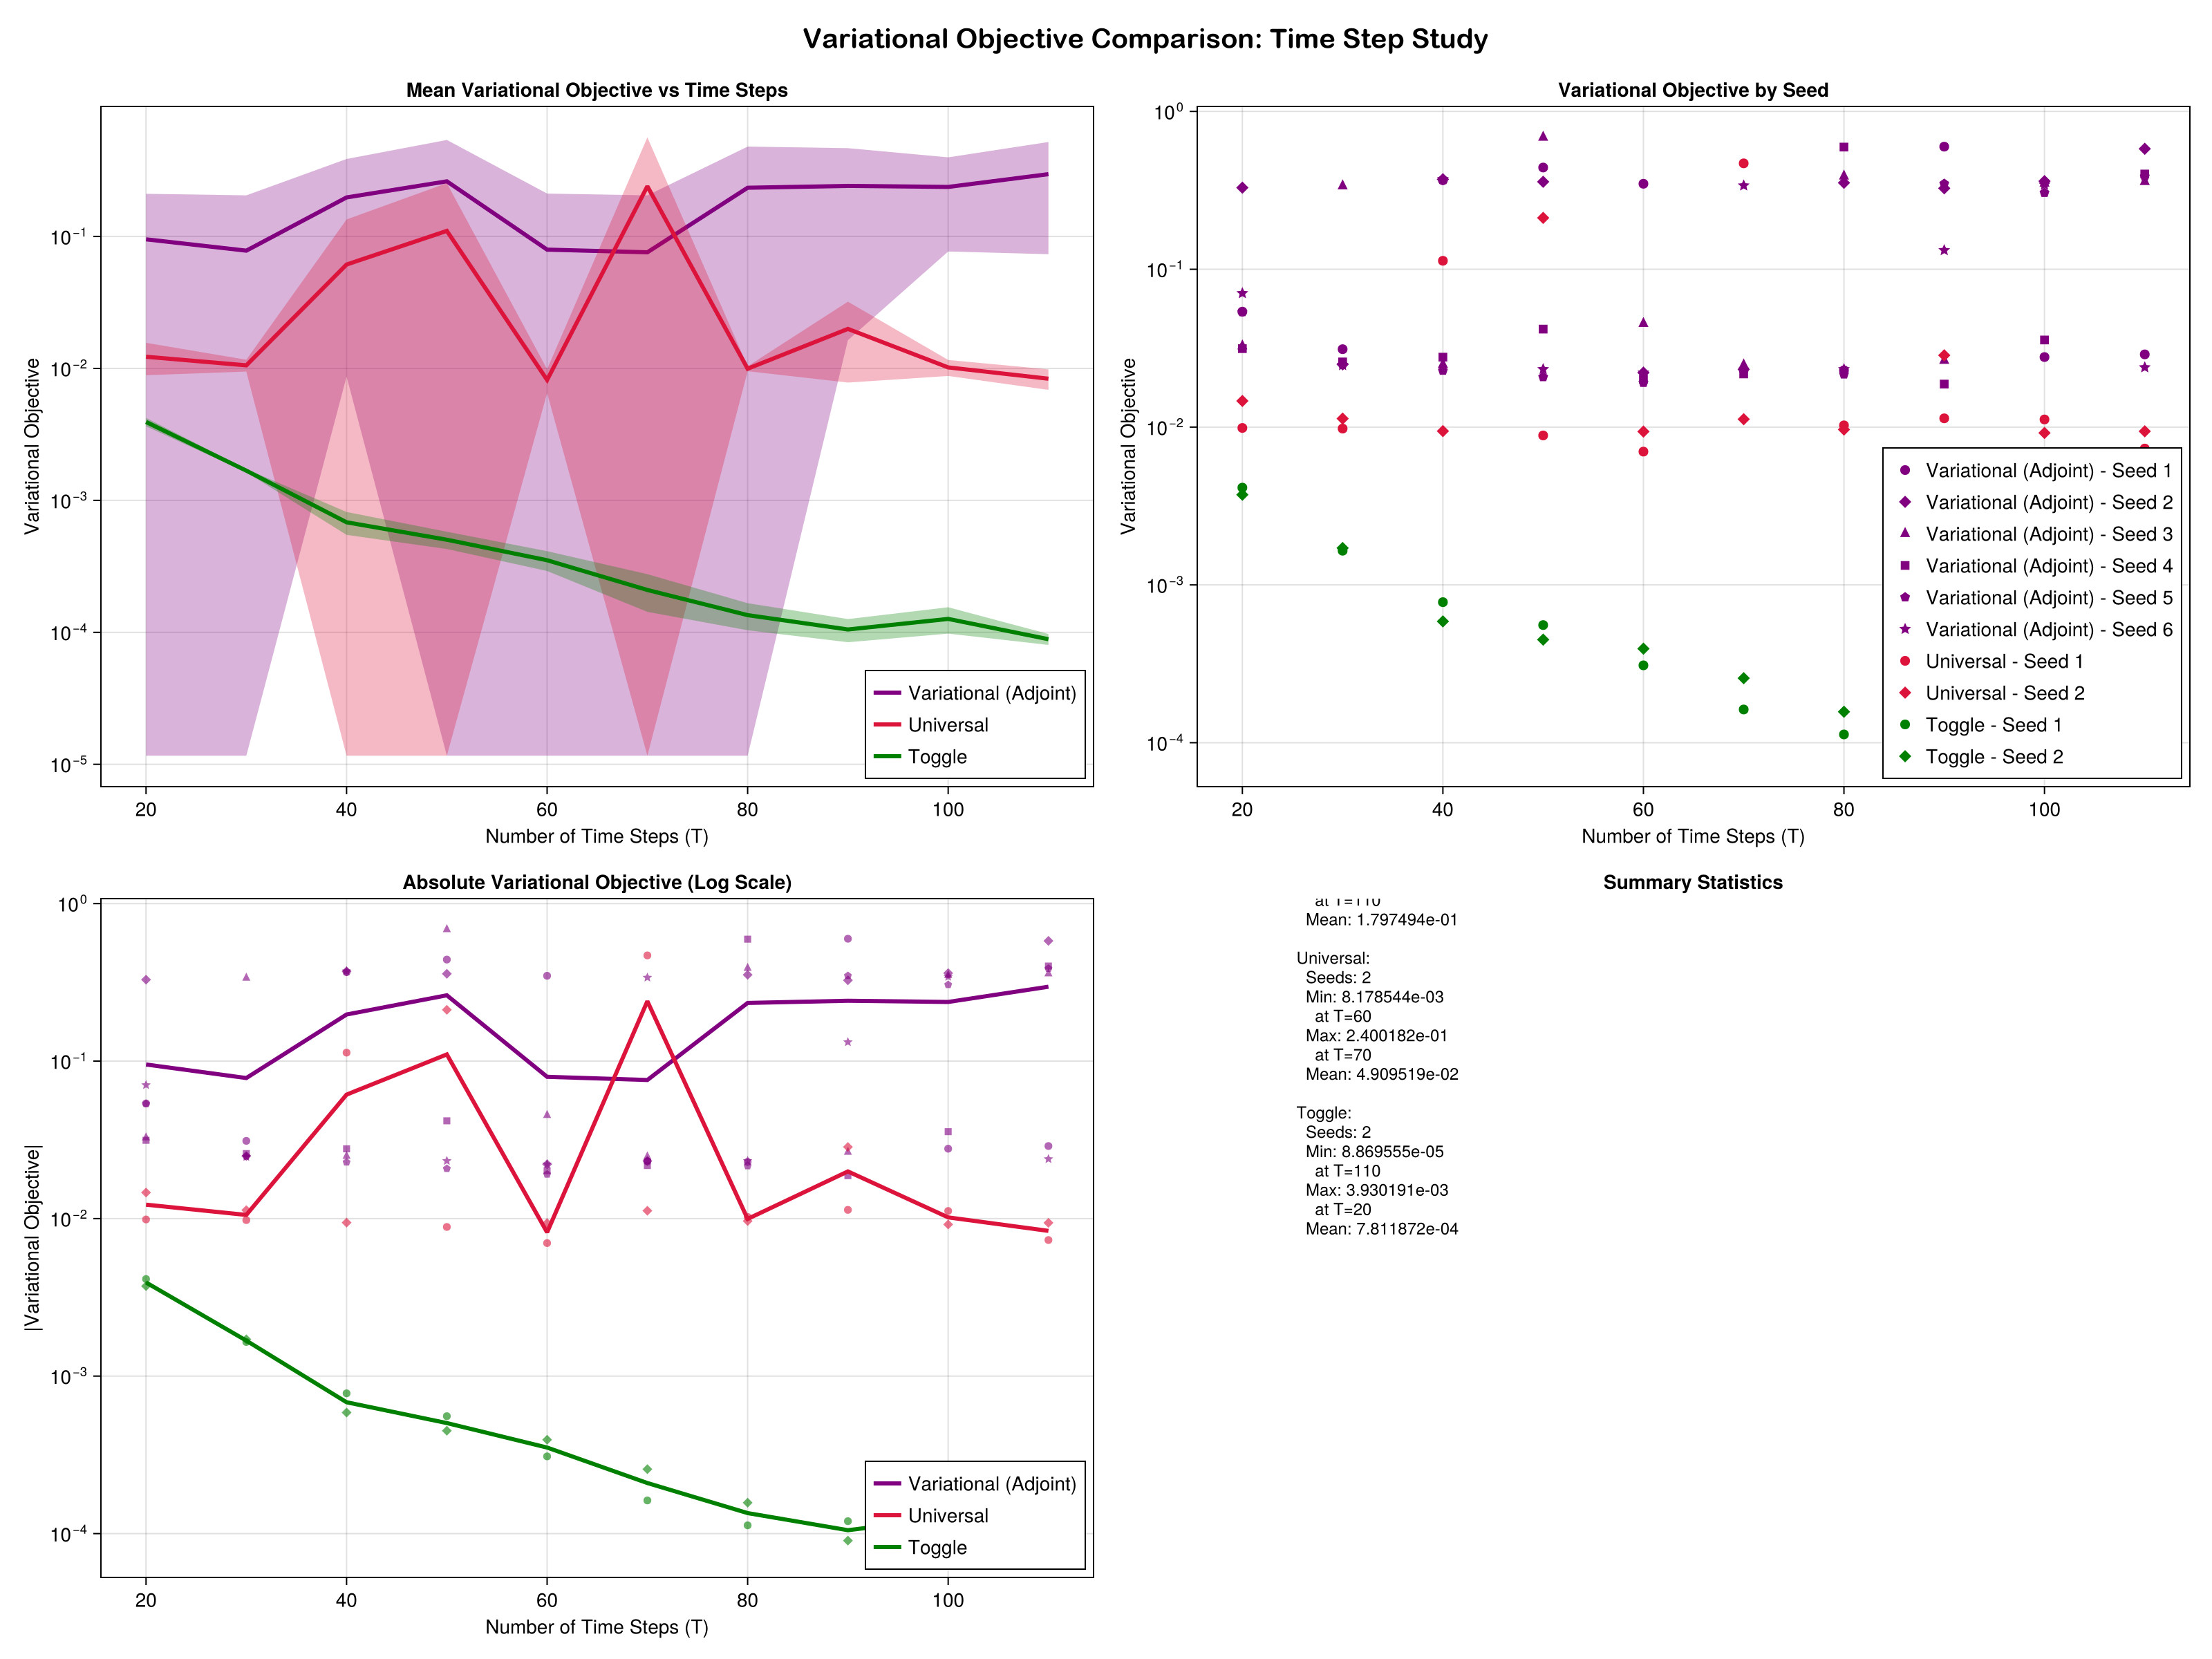



Results saved to: /Users/samafine1/Documents/research/pulses/project/notebooks/src/timestep_study_results/comparison
Figure: variational_objective_comparison_20251001_155814.png
Data: var_obj_data_20251001_155814.jld2
Summary: var_obj_summary_20251001_155814.txt


In [32]:
# Create comprehensive visualization
fig = Figure(size=(1600, 1200))

# Plot 1: Mean variational objective comparison (use log scale only if all positive)
use_log = !has_negative
ax1 = Axis(fig[1, 1],
    title="Mean Variational Objective vs Time Steps",
    xlabel="Number of Time Steps (T)",
    ylabel="Variational Objective",
    yscale=(use_log ? log10 : identity)
)

for method in methods
    if haskey(results, method)
        data = results[method]
        lines!(ax1, data["T_values"], data["mean_var_obj"], 
               color=method_colors[method], linewidth=3, 
               label=method_names[method])
        
        # Only show error bands if they don't go negative on log scale
        upper = data["mean_var_obj"] .+ data["std_var_obj"]
        lower = data["mean_var_obj"] .- data["std_var_obj"]
        
        if use_log
            # Skip bands that would include non-positive values
            lower = max.(lower, min_positive / 10)
        end
        
        band!(ax1, data["T_values"], lower, upper,
              color=(method_colors[method], 0.3))
    end
end
axislegend(ax1, position=:rb)

# Plot 2: Individual seed trajectories
ax2 = Axis(fig[1, 2],
    title="Variational Objective by Seed",
    xlabel="Number of Time Steps (T)",
    ylabel="Variational Objective",
    yscale=(use_log ? log10 : identity)
)

# Expanded marker list to handle up to 10 seeds
markers = [:circle, :diamond, :utriangle, :rect, :pentagon, :star5, :xcross, :dtriangle, :hexagon, :star4]

for method in methods
    if haskey(results, method)
        data = results[method]
        n_seeds = data["n_seeds"]
        
        for seed_idx in 1:n_seeds
            marker_idx = mod1(seed_idx, length(markers))
            scatter!(ax2, data["T_values"], data["var_objectives"][:, seed_idx],
                    color=method_colors[method], marker=markers[marker_idx],
                    markersize=10, 
                    label="$(method_names[method]) - Seed $seed_idx")
        end
    end
end
axislegend(ax2, position=:rb)

# Plot 3: Absolute values on log scale (always safe)
ax3 = Axis(fig[2, 1],
    title="Absolute Variational Objective (Log Scale)",
    xlabel="Number of Time Steps (T)",
    ylabel="|Variational Objective|",
    yscale=log10
)

for method in methods
    if haskey(results, method)
        data = results[method]
        abs_mean = abs.(data["mean_var_obj"])
        n_seeds = data["n_seeds"]
        
        lines!(ax3, data["T_values"], abs_mean,
               color=method_colors[method], linewidth=3,
               label=method_names[method])
        
        for seed_idx in 1:n_seeds
            marker_idx = mod1(seed_idx, length(markers))
            scatter!(ax3, data["T_values"], abs.(data["var_objectives"][:, seed_idx]),
                    color=method_colors[method], marker=markers[marker_idx],
                    markersize=8, alpha=0.6)
        end
    end
end
axislegend(ax3, position=:rb)

# Plot 4: Summary statistics
ax4 = Axis(fig[2, 2],
    title="Summary Statistics"
)
hidedecorations!(ax4)
hidespines!(ax4)

summary_lines = ["Variational Objective Comparison", "="^40, ""]
for method in methods
    if haskey(results, method)
        data = results[method]
        push!(summary_lines, method_names[method] * ":")
        push!(summary_lines, "  Seeds: $(data["n_seeds"])")
        push!(summary_lines, "  Min: $(Printf.@sprintf("%.6e", minimum(data["mean_var_obj"])))")
        push!(summary_lines, "    at T=$(data["T_values"][argmin(data["mean_var_obj"])])")
        push!(summary_lines, "  Max: $(Printf.@sprintf("%.6e", maximum(data["mean_var_obj"])))")
        push!(summary_lines, "    at T=$(data["T_values"][argmax(data["mean_var_obj"])])")
        push!(summary_lines, "  Mean: $(Printf.@sprintf("%.6e", mean(data["mean_var_obj"])))")
        push!(summary_lines, "")
    end
end

if length(results) == 2 && haskey(results, "universal") && haskey(results, "variational")
    push!(summary_lines, "Comparison:")
    
    # Use absolute values for ratio if there are negative values
    if has_negative
        ratio = abs.(results["universal"]["mean_var_obj"]) ./ abs.(results["variational"]["mean_var_obj"])
        push!(summary_lines, "  Abs ratio (U/V):")
    else
        ratio = results["universal"]["mean_var_obj"] ./ results["variational"]["mean_var_obj"]
        push!(summary_lines, "  Ratio (U/V):")
    end
    
    push!(summary_lines, "    Mean: $(Printf.@sprintf("%.4f", mean(ratio)))")
    push!(summary_lines, "    Min: $(Printf.@sprintf("%.4f", minimum(ratio)))")
    push!(summary_lines, "    Max: $(Printf.@sprintf("%.4f", maximum(ratio)))")
end

if has_negative
    push!(summary_lines, "")
    push!(summary_lines, "Note: Negative values detected")
    push!(summary_lines, "Using absolute values for log plots")
end

summary_text = join(summary_lines, "\n")
text!(ax4, 0.1, 0.5, text=summary_text, space=:relative, fontsize=12, font="monospace")

Label(fig[0, :], "Variational Objective Comparison: Time Step Study",
      fontsize=20, font="bold")

display(fig)

# Save results
output_dir = joinpath(@__DIR__, "timestep_study_results", "comparison")
mkpath(output_dir)
timestamp = Dates.format(now(), "yyyymmdd_HHMMSS")

# Save figure
save(joinpath(output_dir, "variational_objective_comparison_$(timestamp).png"), fig, px_per_unit=2)

# Save computed objectives
data_file = joinpath(output_dir, "var_obj_data_$(timestamp).jld2")
@save data_file results TOTAL_DURATION error_op

# Save detailed summary
summary_file = joinpath(output_dir, "var_obj_summary_$(timestamp).txt")
open(summary_file, "w") do io
    println(io, "Variational Objective Comparison")
    println(io, "="^70)
    println(io, "Total Duration: ", TOTAL_DURATION)
    println(io, "Error Operator: Pauli-X")
    println(io, "Has negative values: ", has_negative)
    println(io, "")
    
    for method in methods
        if haskey(results, method)
            println(io, "\n", method_names[method])
            println(io, "-"^70)
            data = results[method]
            println(io, "Number of seeds: ", data["n_seeds"])
            println(io, "")
            for i in 1:length(data["T_values"])
                T = data["T_values"][i]
                println(io, "T=$T:")
                println(io, "  Mean: $(Printf.@sprintf("%.6e", data["mean_var_obj"][i]))")
                println(io, "  Std:  $(Printf.@sprintf("%.6e", data["std_var_obj"][i]))")
                for j in 1:data["n_seeds"]
                    println(io, "  Seed $j: $(Printf.@sprintf("%.6e", data["var_objectives"][i, j]))")
                end
            end
        end
    end
    
    if length(results) == 2 && haskey(results, "universal") && haskey(results, "variational")
        println(io, "\n\nRatio Analysis")
        println(io, "-"^70)
        
        if has_negative
            println(io, "Using absolute values for ratio (negative values present)")
            ratio = abs.(results["universal"]["mean_var_obj"]) ./ abs.(results["variational"]["mean_var_obj"])
        else
            ratio = results["universal"]["mean_var_obj"] ./ results["variational"]["mean_var_obj"]
        end
        
        for i in 1:length(results["universal"]["T_values"])
            T = results["universal"]["T_values"][i]
            println(io, "T=$T: $(Printf.@sprintf("%.4f", ratio[i]))")
        end
    end
end

println("\n\nResults saved to: $(output_dir)")
println("Figure: variational_objective_comparison_$(timestamp).png")
println("Data: var_obj_data_$(timestamp).jld2")
println("Summary: var_obj_summary_$(timestamp).txt")

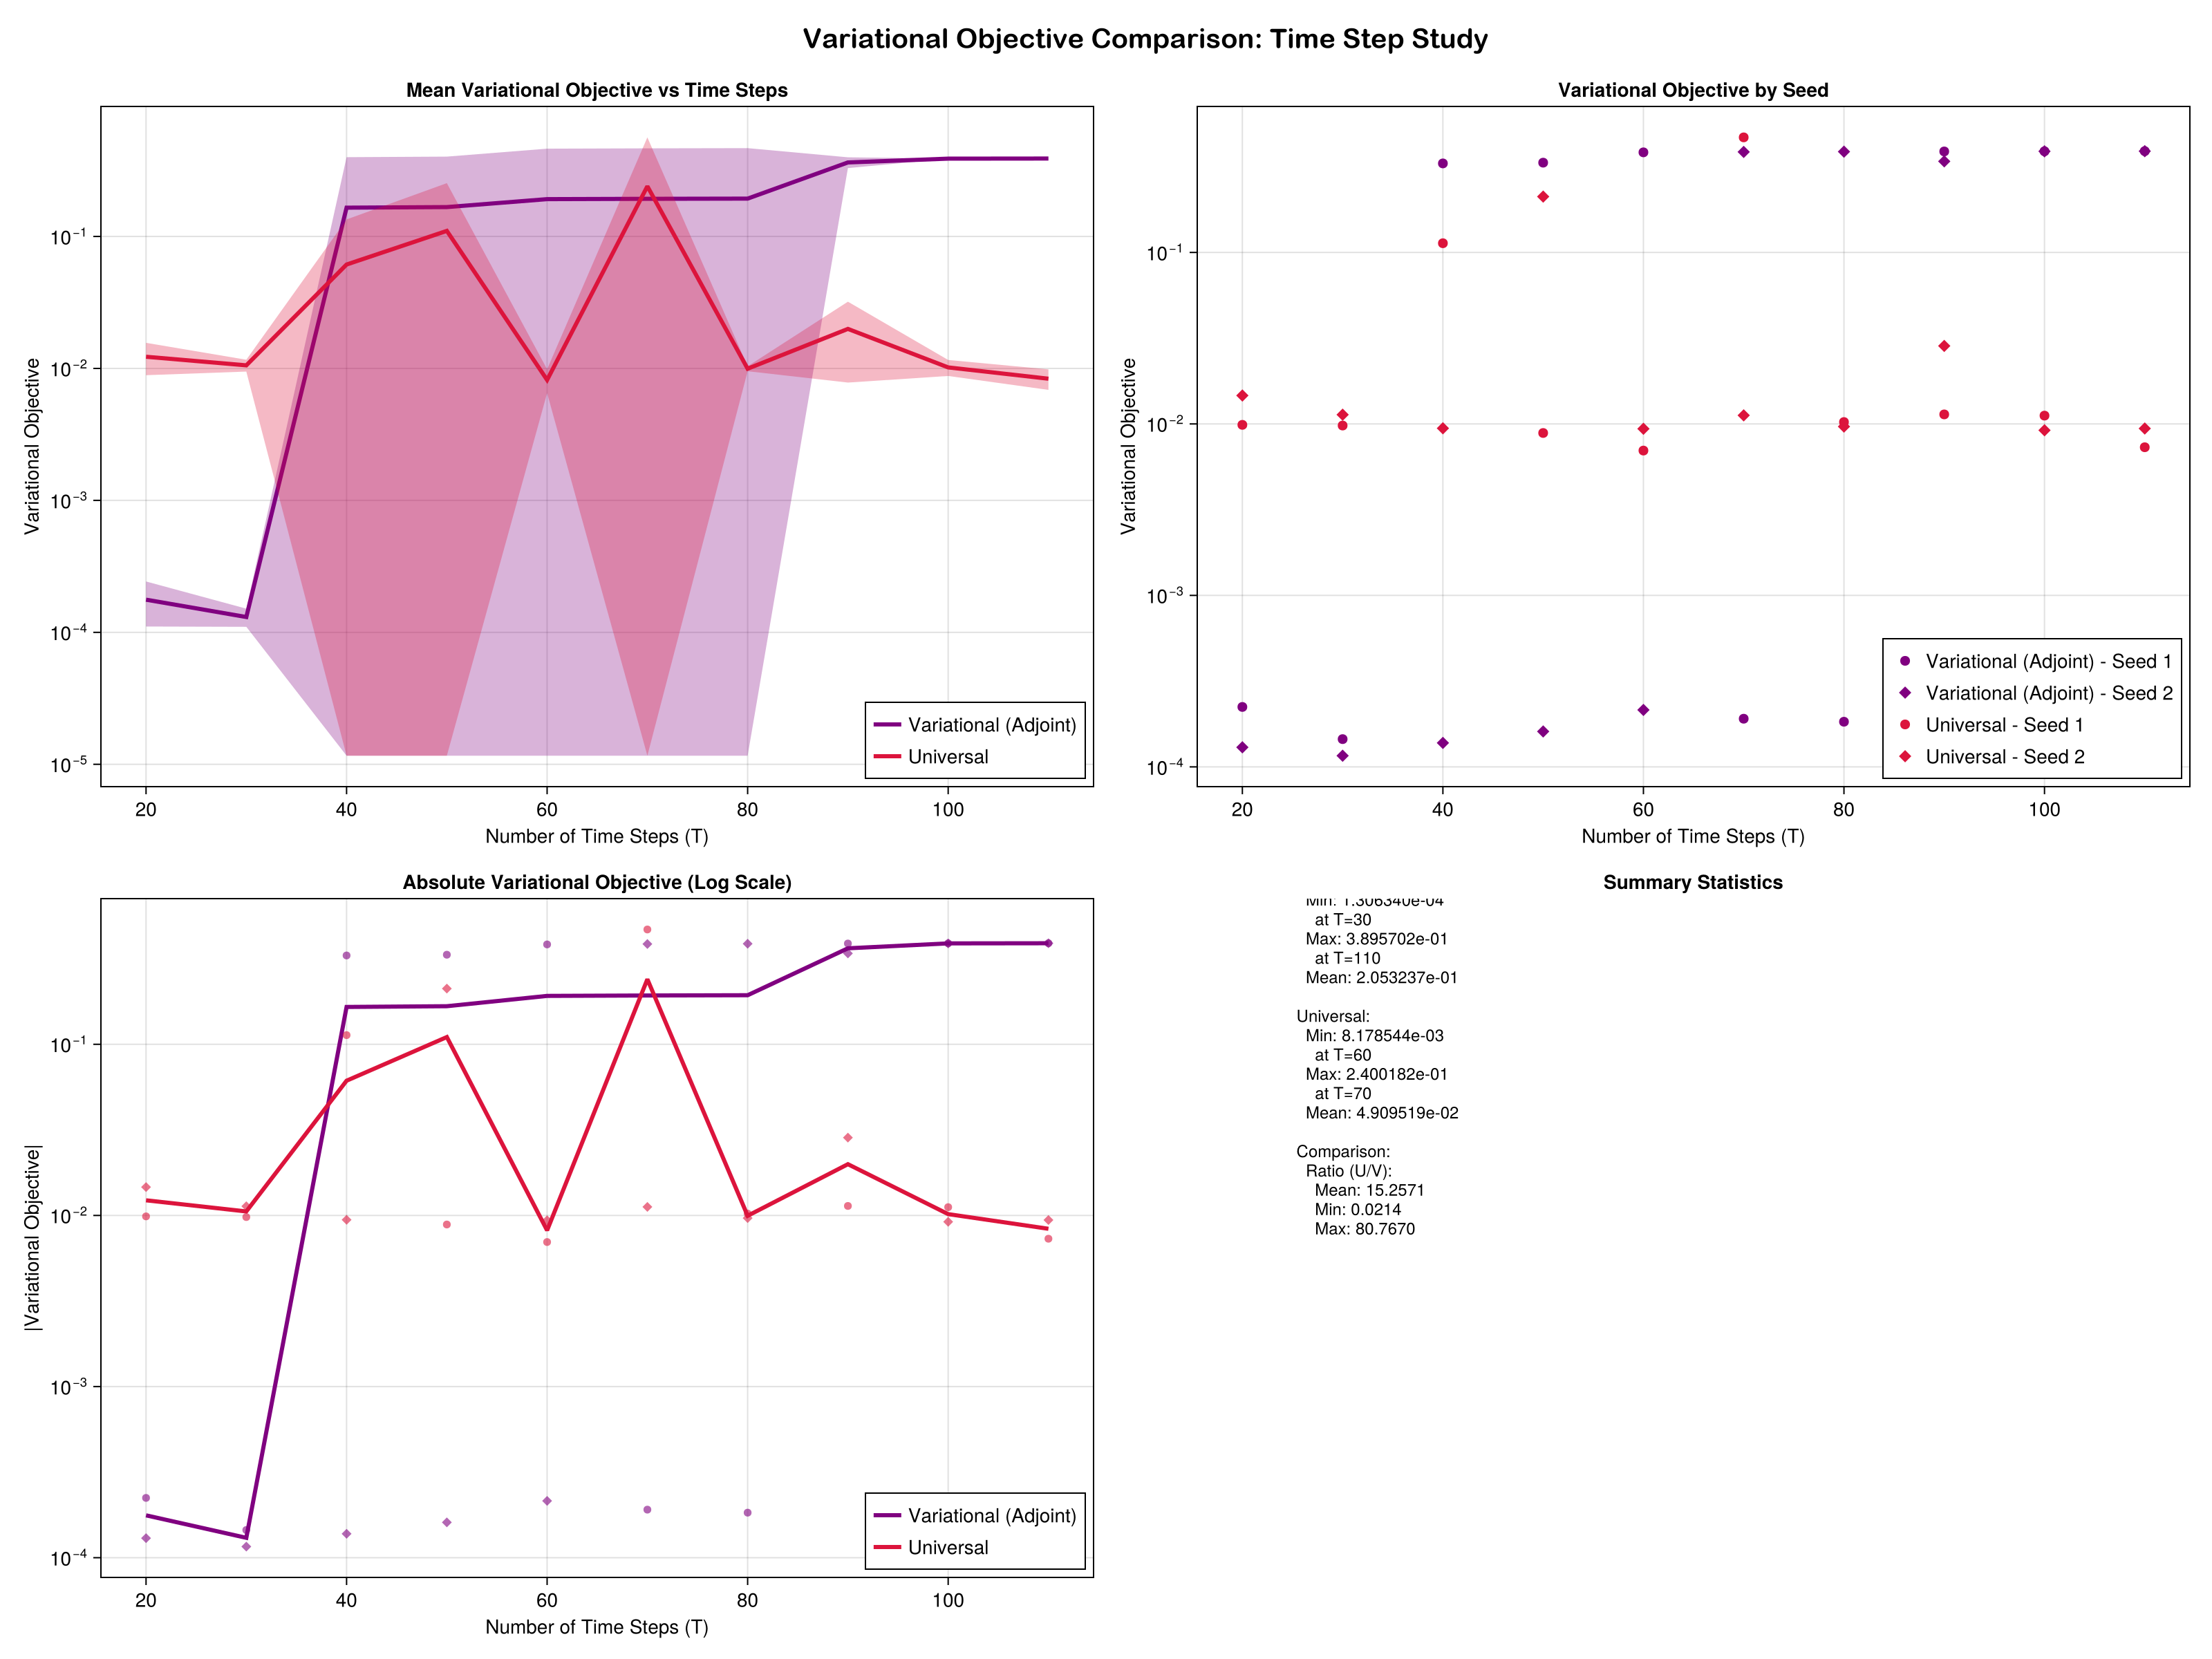



Results saved to: /Users/samafine1/Documents/research/pulses/project/notebooks/src/timestep_study_results/comparison
Figure: variational_objective_comparison_20251001_114823.png
Data: var_obj_data_20251001_114823.jld2
Summary: var_obj_summary_20251001_114823.txt


In [22]:
# Create comprehensive visualization
fig = Figure(size=(1600, 1200))

# Plot 1: Mean variational objective comparison (use log scale only if all positive)
use_log = !has_negative
ax1 = Axis(fig[1, 1],
    title="Mean Variational Objective vs Time Steps",
    xlabel="Number of Time Steps (T)",
    ylabel="Variational Objective",
    yscale=(use_log ? log10 : identity)
)

for method in methods
    if haskey(results, method)
        data = results[method]
        lines!(ax1, data["T_values"], data["mean_var_obj"], 
               color=method_colors[method], linewidth=3, 
               label=method_names[method])
        
        # Only show error bands if they don't go negative on log scale
        upper = data["mean_var_obj"] .+ data["std_var_obj"]
        lower = data["mean_var_obj"] .- data["std_var_obj"]
        
        if use_log
            # Skip bands that would include non-positive values
            lower = max.(lower, min_positive / 10)
        end
        
        band!(ax1, data["T_values"], lower, upper,
              color=(method_colors[method], 0.3))
    end
end
axislegend(ax1, position=:rb)

# Plot 2: Individual seed trajectories
ax2 = Axis(fig[1, 2],
    title="Variational Objective by Seed",
    xlabel="Number of Time Steps (T)",
    ylabel="Variational Objective",
    yscale=(use_log ? log10 : identity)
)

markers = [:circle, :diamond, :utriangle, :rect]
for method in methods
    if haskey(results, method)
        data = results[method]
        for seed_idx in 1:data["n_seeds"]
            scatter!(ax2, data["T_values"], data["var_objectives"][:, seed_idx],
                    color=method_colors[method], marker=markers[seed_idx],
                    markersize=10, 
                    label="$(method_names[method]) - Seed $seed_idx")
        end
    end
end
axislegend(ax2, position=:rb)

# Plot 3: Absolute values on log scale (always safe)
ax3 = Axis(fig[2, 1],
    title="Absolute Variational Objective (Log Scale)",
    xlabel="Number of Time Steps (T)",
    ylabel="|Variational Objective|",
    yscale=log10
)

for method in methods
    if haskey(results, method)
        data = results[method]
        abs_mean = abs.(data["mean_var_obj"])
        lines!(ax3, data["T_values"], abs_mean,
               color=method_colors[method], linewidth=3,
               label=method_names[method])
        
        for seed_idx in 1:data["n_seeds"]
            scatter!(ax3, data["T_values"], abs.(data["var_objectives"][:, seed_idx]),
                    color=method_colors[method], marker=markers[seed_idx],
                    markersize=8, alpha=0.6)
        end
    end
end
axislegend(ax3, position=:rb)

# Plot 4: Summary statistics
ax4 = Axis(fig[2, 2],
    title="Summary Statistics"
)
hidedecorations!(ax4)
hidespines!(ax4)

summary_lines = ["Variational Objective Comparison", "="^40, ""]
for method in methods
    if haskey(results, method)
        data = results[method]
        push!(summary_lines, method_names[method] * ":")
        push!(summary_lines, "  Min: $(Printf.@sprintf("%.6e", minimum(data["mean_var_obj"])))")
        push!(summary_lines, "    at T=$(data["T_values"][argmin(data["mean_var_obj"])])")
        push!(summary_lines, "  Max: $(Printf.@sprintf("%.6e", maximum(data["mean_var_obj"])))")
        push!(summary_lines, "    at T=$(data["T_values"][argmax(data["mean_var_obj"])])")
        push!(summary_lines, "  Mean: $(Printf.@sprintf("%.6e", mean(data["mean_var_obj"])))")
        push!(summary_lines, "")
    end
end

if length(results) == 2 && haskey(results, "universal") && haskey(results, "variational")
    push!(summary_lines, "Comparison:")
    
    # Use absolute values for ratio if there are negative values
    if has_negative
        ratio = abs.(results["universal"]["mean_var_obj"]) ./ abs.(results["variational"]["mean_var_obj"])
        push!(summary_lines, "  Abs ratio (U/V):")
    else
        ratio = results["universal"]["mean_var_obj"] ./ results["variational"]["mean_var_obj"]
        push!(summary_lines, "  Ratio (U/V):")
    end
    
    push!(summary_lines, "    Mean: $(Printf.@sprintf("%.4f", mean(ratio)))")
    push!(summary_lines, "    Min: $(Printf.@sprintf("%.4f", minimum(ratio)))")
    push!(summary_lines, "    Max: $(Printf.@sprintf("%.4f", maximum(ratio)))")
end

if has_negative
    push!(summary_lines, "")
    push!(summary_lines, "Note: Negative values detected")
    push!(summary_lines, "Using absolute values for log plots")
end

summary_text = join(summary_lines, "\n")
text!(ax4, 0.1, 0.5, text=summary_text, space=:relative, fontsize=12, font="monospace")

Label(fig[0, :], "Variational Objective Comparison: Time Step Study",
      fontsize=20, font="bold")

display(fig)

# Save results
output_dir = joinpath(@__DIR__, "timestep_study_results", "comparison")
mkpath(output_dir)
timestamp = Dates.format(now(), "yyyymmdd_HHMMSS")

# Save figure
save(joinpath(output_dir, "variational_objective_comparison_$(timestamp).png"), fig, px_per_unit=2)

# Save computed objectives
data_file = joinpath(output_dir, "var_obj_data_$(timestamp).jld2")
@save data_file results TOTAL_DURATION error_op

# Save detailed summary
summary_file = joinpath(output_dir, "var_obj_summary_$(timestamp).txt")
open(summary_file, "w") do io
    println(io, "Variational Objective Comparison")
    println(io, "="^70)
    println(io, "Total Duration: ", TOTAL_DURATION)
    println(io, "Error Operator: Pauli-X")
    println(io, "Has negative values: ", has_negative)
    println(io, "")
    
    for method in methods
        if haskey(results, method)
            println(io, "\n", method_names[method])
            println(io, "-"^70)
            data = results[method]
            for i in 1:length(data["T_values"])
                T = data["T_values"][i]
                println(io, "T=$T:")
                println(io, "  Mean: $(Printf.@sprintf("%.6e", data["mean_var_obj"][i]))")
                println(io, "  Std:  $(Printf.@sprintf("%.6e", data["std_var_obj"][i]))")
                for j in 1:data["n_seeds"]
                    println(io, "  Seed $j: $(Printf.@sprintf("%.6e", data["var_objectives"][i, j]))")
                end
            end
        end
    end
    
    if length(results) == 2 && haskey(results, "universal") && haskey(results, "variational")
        println(io, "\n\nRatio Analysis")
        println(io, "-"^70)
        
        if has_negative
            println(io, "Using absolute values for ratio (negative values present)")
            ratio = abs.(results["universal"]["mean_var_obj"]) ./ abs.(results["variational"]["mean_var_obj"])
        else
            ratio = results["universal"]["mean_var_obj"] ./ results["variational"]["mean_var_obj"]
        end
        
        for i in 1:length(results["universal"]["T_values"])
            T = results["universal"]["T_values"][i]
            println(io, "T=$T: $(Printf.@sprintf("%.4f", ratio[i]))")
        end
    end
end

println("\n\nResults saved to: $(output_dir)")
println("Figure: variational_objective_comparison_$(timestamp).png")
println("Data: var_obj_data_$(timestamp).jld2")
println("Summary: var_obj_summary_$(timestamp).txt")